In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]


from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer

import xgboost as xgb

### Load the data

In [4]:
day_of_week='Wednesday'

data_directory='../data/processed'
file_name=day_of_week+'_processed.pkl'

data_file=os.path.join(data_directory,file_name)

In [5]:
df=pd.read_pickle(data_file)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,-0.171623,-1.525682,-0.537383,-0.985881,-0.854012,-0.906670,0.699029,-0.825948,-0.892973,...,-1.068829,-0.668233,-0.262388,-0.667497,-0.668941,-0.704934,-0.2817,-0.704936,-0.704909,BENIGN
1,389,-0.857651,1.353208,0.711236,0.333602,0.161480,0.152381,-0.825974,-0.337056,0.732250,...,0.833512,-0.668233,-0.262388,-0.667497,-0.668941,-0.704934,-0.2817,-0.704936,-0.704909,BENIGN
2,88,-0.733438,1.277448,0.859972,1.877072,0.812508,1.874575,-0.825974,2.014803,1.491230,...,0.833512,-0.668233,-0.262388,-0.667497,-0.668941,-0.704934,-0.2817,-0.704936,-0.704909,BENIGN
3,389,-0.322022,1.654655,1.401459,1.932152,1.036734,1.753461,-0.825974,1.583637,1.412771,...,0.833512,-0.668233,-0.262388,-0.667497,-0.668941,-0.704934,-0.2817,-0.704936,-0.704909,BENIGN
4,88,-0.733854,1.189372,0.859972,1.877072,0.812696,1.874575,-0.825974,2.123422,1.508930,...,0.833512,-0.668233,-0.262388,-0.667497,-0.668941,-0.704934,-0.2817,-0.704936,-0.704909,BENIGN


In [6]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

## Preparing the Dataset for Classification 

Here we need to separate our class variable, which in our case is "Label" from the rest of the dataset.

In [7]:
y=np.array(df['Label'])
y

array(['BENIGN', 'BENIGN', 'BENIGN', ..., 'BENIGN', 'BENIGN', 'BENIGN'],
      dtype=object)

In [8]:
y_binary= y!='BENIGN'
y_binary.astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [9]:
X=np.array(df.loc[:, df.columns != 'Label'])
X.shape

(691406, 67)

## Training and predicting XGBoost w/ cross validation

We will use 5-fold cross validation to evaluate the performance of the xgboost classifier on our dataset.

https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn

In [10]:
kfold = KFold(n_splits=5, shufday_of_weekue, random_state=55)

cm = []
acc = []
auc_score = []

for train_index, test_index in kfold.split(X):   
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_binary[train_index], y_binary[test_index]

    xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
    xgb_model.fit(X_train, y_train)
    
    y_pred = xgb_model.predict(X_test)
    
    cm.append(confusion_matrix(y_test,y_pred))
    acc.append(accuracy_score(y_test,y_pred))
    auc_score.append(roc_auc_score(y_test,y_pred))
    

In [15]:
display_scores(acc)

Scores: [0.9984813641688723, 0.9984596582321504, 0.9983222568537977, 0.9982933302478287, 0.9981559288694759]
Mean: 0.998
Std: 0.000


In [16]:
display_scores(auc_score)

Scores: [0.9987039015025628, 0.9986227694583334, 0.9985249598593898, 0.9984957230306675, 0.9983597266869628]
Mean: 0.999
Std: 0.000


## Save the trained model

Let's pickle our saved model as a serialized binary file for later fetching.

In [13]:
filename='./models/xgb_model_'+day_of_week+'.pkl'

with open(filename,'wb') as file:
    pickle.dump(xgb_model,file)

## Load the pretrained xgboost model

Use the following snippet of code to load the xgboost model for further analysis

In [27]:
with open(filename,'rb') as file:
    loaded_model=pickle.load(file)

<Figure size 864x720 with 0 Axes>

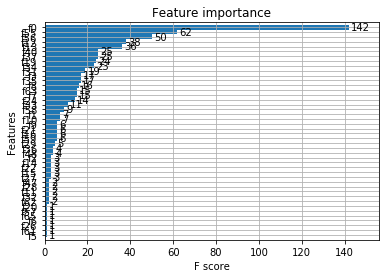

In [20]:
fig=plt.figure(figsize=(12,10))
xgb.plot_importance(xgb_model,height=1)